In [37]:
def generate_continuous_plot_data (price_result, market_price, nominal=True):
    import numpy as np
    import pandas as pd
    
    '''
    price_result: one balance strategy only
    '''
    price_df_list = market_price
    
    plot_data_list = []
    
    # 1. Get Nominal Price Transaction Records
    trans_date_df = pd.DataFrame([tmp['Date']for tmp in price_result], columns = ['Date']) 
    # ^ Action dates in the five years
    trans_df_list = []

    for market_num in range(3): # nominal_df_list[0-2] for three assets
        asset_df = pd.DataFrame([tmp['Record'][market_num] for tmp in price_result]) 
        # ^ Get the asset weightage at each time
        result_df = pd.concat([trans_date_df, asset_df], axis=1)
        result_df.rename(columns={'0':'Date'}, inplace=True)
        trans_df_list.append(result_df)
    
    for market_num in range(3):
        tmp_trans_df = trans_df_list[market_num]
        trans_date = tmp_trans_df['Date']
        start_date = list(trans_date)[0]
        end_date = list(price_df_list[0]['Date'])[-1]

        history_df = price_df_list[market_num]
        all_price_date = history_df['Date'][(history_df['Date']>=start_date) & (history_df['Date']<= end_date)]
        plot_data = []
        number = 0
        net_value = 0
        price = 0
        for date in all_price_date:
            if (trans_date == date).any(): # If rebalanced at that day:
                number = tmp_trans_df['Number'][tmp_trans_df['Date']==date].values[0]
                net_value = tmp_trans_df['Net Value'][tmp_trans_df['Date']==date].values[0]
                price = tmp_trans_df['Price'][tmp_trans_df['Date']==date].values[0]
            else:
                if nominal:
                    price = history_df['Price'][history_df['Date']==date].values[0]
                else:
                    price = history_df['Actual Price'][history_df['Date']==date].values[0]

                net_value = number*price
            plot_data.append({
                "Date": date,
                "Number": number,
                "Price": price,
                "Net Value": net_value
            })
        plot_data_list.append(plot_data)
        
    return trans_df_list, plot_data_list

In [38]:
def generate_graph(nominal_plot_data_list, actual_plot_data_list, nominal_trans_df_list, actual_trans_df_list):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.gridspec import GridSpec
    from CSVUtils import csv2df

    DIR = "./from github/Stock-Trading-Environment/data"
    file_names = ["^BVSP", "^TWII", "^IXIC"]
    source_list = ["yahoo", "yahoo", "yahoo"] # for plotting price data

    nominal_labels = ["high risk-^BVSP_nominal", "mid risk-^TWII_nominal", "low risk-^IXIC"]
    actual_labels = ["high risk-^BVSP_actual", "mid risk-^TWII_actual", "low rick-^IXIC"]


    plt.rcParams['figure.facecolor'] = 'white'
    fig=plt.figure(figsize=(40,25))
    axs = []
    gs=GridSpec(5,1) # 5 rows, 1 columns
    axs.append(fig.add_subplot(gs[0,0])) # First row, first column
    axs.append(fig.add_subplot(gs[1,0])) # First row, second column
    axs.append(fig.add_subplot(gs[2,0])) # First row, third column
    axs.append(fig.add_subplot(gs[3:,:])) # Second row, span all columns



    for i, plot_data in enumerate(nominal_plot_data_list):
        plot_data = pd.DataFrame(plot_data)

        axs[i].plot(plot_data['Date'], np.log(plot_data['Net Value']/plot_data['Net Value'][0]), 
                    color="C0", label = nominal_labels[i]+"_Log Market Value")
        axs[i].bar(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/nominal_trans_df_list[i]['Net Value'][0]), 
                   width=2, color="C0")
        axs[i].plot(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/nominal_trans_df_list[i]['Net Value'][0]), 
                    linestyle='--', color="C0", label = nominal_labels[i]+"_Log Book Value")

        axs[i].axhline(y=0, color = "grey", linestyle='--')
        axs[i].legend()
        axs[i].set_title('Portfolio Weights')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Market Value (US$)')


    for i, plot_data in enumerate(actual_plot_data_list):
        plot_data = pd.DataFrame(plot_data)

        axs[i].plot(plot_data['Date'], np.log(plot_data['Net Value']/plot_data['Net Value'][0]), 
                    color="orange", label = actual_labels[i]+"_Log Market Value")
        axs[i].bar(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/actual_trans_df_list[i]['Net Value'][0]), 
                   width=2, color="orange")

        axs[i].plot(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/actual_trans_df_list[i]['Net Value'][0]), 
                    linestyle='--', color="orange", label = actual_labels[i]+"_Log Book Value")
        axs[i].plot(price_df_list[i]['Date'], np.log(price_df_list[i]['Cum FX Change']),
                    color="green", linestyle='--', label = nominal_labels[i]+"_Log FX Change")


        axs[i].axhline(y=0, color = "grey", linestyle='--')
    #     axs[i].set_ylim((0, 300000))
        axs[i].set_title('Log Portfolio Value')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Log Value')



    for i in range(2,-1,-1): # Inverse: Low-Mid-High
        df = csv2df(DIR, file_names[i]+".csv",source = source_list[i])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[(df['Date']>=pd.to_datetime("2015-01-01"))&(df['Date']<=pd.to_datetime("2019-12-31"))].reset_index(drop=True)

        j = 0
        init_price = df['Price'][j]
        while np.isnan(init_price):
            j+=1
            init_price = df['Price'][j]
        y = np.log(df['Price'][j:] / init_price)
        x = df['Date'][j:]
        axs[3].plot(x,y,label = nominal_labels[i])
        axs[i].plot(x,y, color = "pink", linestyle='--', label = nominal_labels[i]+"_Log Nominal Price")
        axs[i].legend()

    axs[3].axhline(y=0, color = "grey", linestyle='--')
    # axs[3].set_ylim((-1,1))
    axs[3].legend()
    axs[3].set_title('Log Market Price')
    axs[3].set_xlabel('Date')
    axs[3].set_ylabel('log(Market Price)')
    plt.show()

In [40]:
def plot_rebalance_record(nominal_price_result, actual_price_result, market_price):
    '''
    rebalance_record = [nominal_price_result, actual_price_result];
    nominal_price_resul[0-3]: The Transaction Records for evenly rebalancing the portfolio for [1 year, 6 months, 3 months, 1 month], REGARDLESS of Commission Cost and FX Change;
    actual_price_result[0-3]: The Transaction Records for evenly rebalancing the portfolio for [1 year, 6 months, 3 months, 1 month], CONSIDERING of Commission Cost and FX Change;
    
    price_df_list[0-2]: The History data for three indexes [^BVSP, ^TWII, ^IXIC] within a given range, with:
    Nominal Price['Price'], and Actual Price ['Actual Price'], where the Cummulative FX Change ['Cum FX Change'] is considered
    '''
    
    nominal_trans_df_list, nominal_plot_data_list = generate_continuous_plot_data(nominal_price_result, market_price, nominal=True)
    actual_trans_df_list, actual_plot_data_list = generate_continuous_plot_data(actual_price_result, market_price, nominal=False)

    generate_graph(nominal_plot_data_list, actual_plot_data_list, nominal_trans_df_list, actual_trans_df_list)

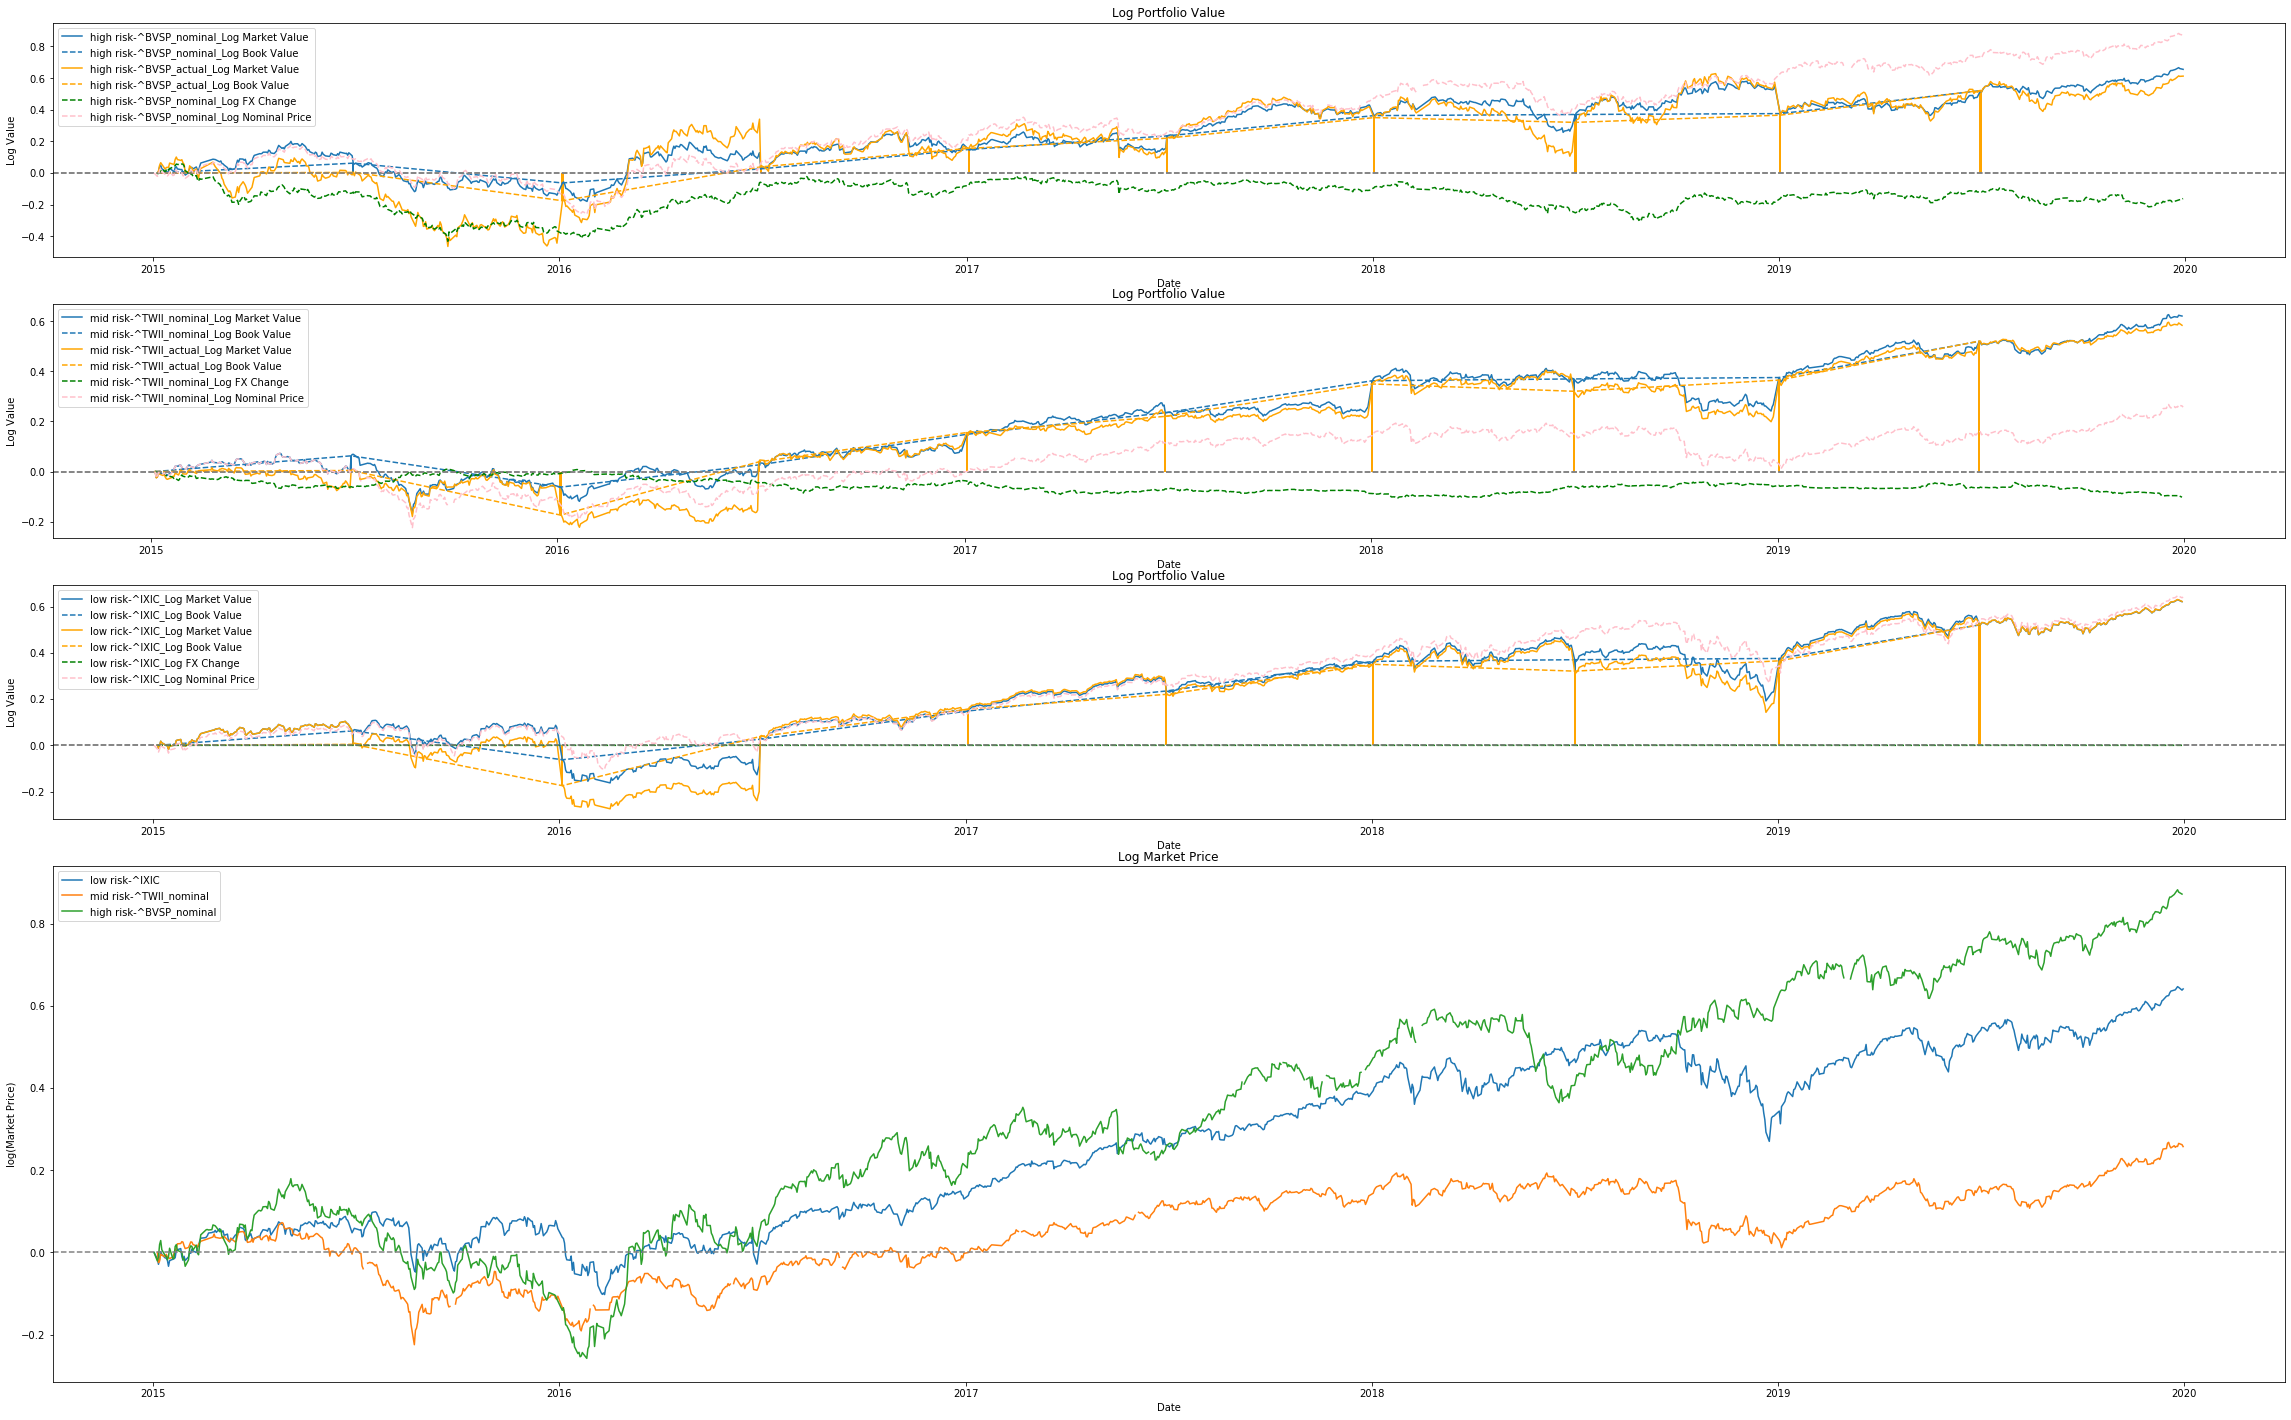

In [41]:
import pickle

tmp = pickle.load(open("0306-currency adjusted rebalance record.out", "rb"))
nominal_price_result = tmp[0][1] # Six Months
actual_price_result = tmp[1][1]
price_df_list = pickle.load(open("0306-adjusted market prices.out", "rb"))

plot_rebalance_record(nominal_price_result, actual_price_result, price_df_list)